# **DESAFIO 3 G2** 
# **Dataset Imagenes Covid-19 - Modelo de clasificacion supervisado.**
---

<a id="sec_imp"></a> 
### Importaciones y carga de bibliotecas

[volver a TOC](#section_toc)

In [1]:
!pip install opencv-python
!pip install scikit-image

#### Importacion de bibliotecas generales

In [2]:
import os
import sys
import re

In [3]:
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import cv2
import skimage
import skimage.io
import skimage.transform

In [6]:
import pickle

#### Importacion de librerias para armado y testeo de modelos

In [7]:
# operaciones sobre variables
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline, make_union

# modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

# modelos de regresion
from sklearn.linear_model import LinearRegression

# normalizacion de variables
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

In [8]:
with open('model_lr.pkl', 'rb') as lr_model:
        logistic_regression = pickle.load(lr_model)

(2249, 2809, 3)
(2249, 2809)


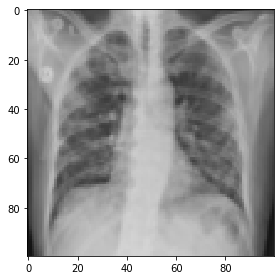

In [9]:
#### cargo imagen
# imagen a color x defecto: np array de 3 dimensiones: (row/x/heigh,column/y/lengh,z/depth/RGB channels)
Xi = skimage.io.imread('../data/7.jpg')
print(Xi.shape)

# one channel only. 2 dimension array
Xi = skimage.color.rgb2gray(Xi)
print(Xi.shape)
display(skimage.io.imshow(Xi))

# resize 2 dimensional array
Xi = skimage.transform.resize(Xi, (100,100))
display(skimage.io.imshow(Xi))

100

100

array([0.56122262, 0.57872426, 0.59799032, ..., 0.08377847, 0.10009279,
       0.11272421])

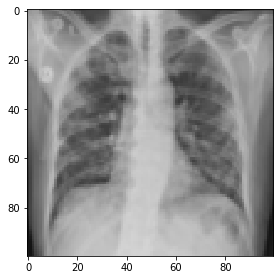

In [10]:
## extraigo tamaño filas y columnas con np.shape
rows,cols = Xi.shape
# calculo longitud total para armar 1 dimension y aplico np.reshape
img_size = rows*cols
img_1D_vector = Xi.reshape(img_size)
display(rows,cols)
display(img_1D_vector)

# recupero 2 dimensiones concatenando filas y columnas para re armar el array
Xj = img_1D_vector.reshape(rows,cols)
skimage.io.imshow(Xj)

In [11]:
#Generate segmentation for image
# NO USO QUICKSHIFT Y USO SLIC BASADO EN K MEANS porque trabaja con imagenes de 2 dimensiones como utilizamos nosotros.
# https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic
# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html

# analizar los parametros. Ni idea que hacen. compactness permite que los superpixeles no sean cuadrados perfectos y no termine siendo una grilla.
import skimage.segmentation
superpixels = skimage.segmentation.slic(Xj, n_segments=100, compactness=0.2, sigma=1, start_label=1)

In [12]:
display(superpixels.shape)
display(superpixels)

(100, 100)

array([[ 1,  1,  1, ..., 10, 10, 10],
       [ 1,  1,  1, ..., 10, 10, 10],
       [ 1,  1,  1, ..., 10, 10, 10],
       ...,
       [91, 91, 91, ..., 92, 92, 92],
       [91, 91, 91, ..., 92, 92, 92],
       [91, 91, 91, ..., 92, 92, 92]])

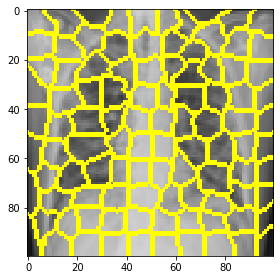

In [13]:
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xj, superpixels))

In [14]:
display((np.ones(np.unique(superpixels).shape[0])[np.newaxis,:]).shape)
superpixels.shape

(1, 100)

(100, 100)

In [15]:
#Generate perturbations
num_perturb = 150 # numero de perturbaciones
trial_prob = 0.5 # probabilidad de cada intento
times_test = 1 # cantidad de intentos

perturbations = np.random.binomial(times_test, trial_prob, size=(num_perturb, num_superpixels))
perturbations

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 1, 0]])

In [16]:
display(perturbations[0]) # tomo la primera linea de permutaciones
display(np.sum(perturbations[0] == 1)) # tomo aquellos valores de la primera linea de permutaciones que sean 1 y valculo cuantos valores son
display(len(np.where(perturbations[0] == 1)[0])) # aplico funcion where para cambiar valores y verifico que sea la misma cantidad que los valores 1
np.where(perturbations[0] == 1)[0]

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

47

47

array([ 1,  4,  8, 10, 11, 13, 14, 16, 17, 18, 19, 20, 23, 24, 27, 29, 30,
       31, 32, 33, 34, 36, 38, 39, 40, 41, 56, 58, 61, 63, 65, 66, 68, 69,
       70, 71, 72, 74, 75, 78, 79, 81, 82, 84, 87, 89, 92])

[0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1
 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0
 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0]
[[0.56122262 0.57872426 0.59799032 ... 0.33486231 0.318369   0.28806267]
 [0.59020082 0.59731809 0.61364776 ... 0.4045581  0.38751176 0.37663823]
 [0.61629907 0.61476292 0.61993366 ... 0.52471053 0.47530846 0.44196022]
 ...
 [0.         0.         0.         ... 0.08152384 0.09641962 0.11030837]
 [0.         0.         0.         ... 0.08270241 0.09796173 0.11158134]
 [0.         0.         0.         ... 0.08377847 0.10009279 0.11272421]]


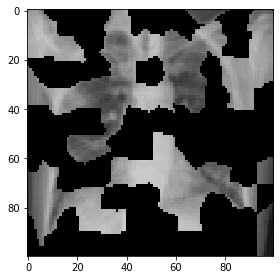

In [17]:
#Create function to apply perturbations to images
import copy
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask
  return perturbed_image

#Show example of perturbations
print(perturbations[0]) 
skimage.io.imshow(perturb_image(Xi,perturbations[0],superpixels))
print((perturb_image(Xi,perturbations[0],superpixels)))

In [18]:
perturbed_img = perturb_image(Xi,perturbations[0],superpixels)
print(perturbed_img.reshape(rows*cols).shape)
perturbed_img.reshape(rows*cols).reshape(1,-1)

(10000,)


array([[0.56122262, 0.57872426, 0.59799032, ..., 0.08377847, 0.10009279,
        0.11272421]])

In [19]:
## se arma una lista con las predicciones. 
# no usamos metodos de redes neuronales, sino regresion logistica, por eso el input tiene que ser una Serie de Panda o un np array de dos dimensiones.
# como partimos de un vector falseamos la 2da dimension mediante .reshape(1,-1)

predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi,pert,superpixels)
    rows,cols = perturbed_img.shape
    perturbed_img_1d = perturbed_img.reshape(rows*cols)
    pred = logistic_regression.predict(perturbed_img_1d.reshape(1,-1))
    predictions.append(pred)

predictions = np.array(predictions)

https://towardsdatascience.com/interpretable-machine-learning-for-image-classification-with-lime-ea947e82ca13

In [20]:
#Compute distances to original image
import sklearn.metrics
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances.shape)
print(distances[0:10])

#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights.shape)
print(weights[0:10])

(150,)
[0.31443454 0.28585716 0.31443454 0.27888974 0.25166852 0.31443454
 0.28585716 0.25838015 0.28585716 0.36754447]
(150,)
[0.45341265 0.52011023 0.45341265 0.53674298 0.60248268 0.45341265
 0.52011023 0.58620693 0.52011023 0.33935399]


In [21]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions, sample_weight=weights)
coeff = simpler_model.coef_[0]
#coeff

In [22]:
num_top_features = 20
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([45, 59,  5, 27, 77, 69, 51, 26, 24, 61, 48, 28, 42, 34, 38, 56, 35,
        8, 52, 13])

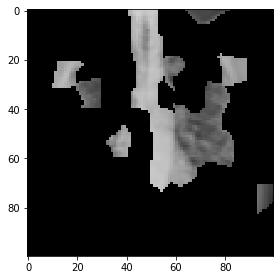

In [23]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi,mask,superpixels) )

---

### Uso directamente los metodos y atributos desde lime

In [24]:
Xi

array([[0.56122262, 0.57872426, 0.59799032, ..., 0.33486231, 0.318369  ,
        0.28806267],
       [0.59020082, 0.59731809, 0.61364776, ..., 0.4045581 , 0.38751176,
        0.37663823],
       [0.61629907, 0.61476292, 0.61993366, ..., 0.52471053, 0.47530846,
        0.44196022],
       ...,
       [0.08734949, 0.07590588, 0.15955459, ..., 0.08152384, 0.09641962,
        0.11030837],
       [0.09005292, 0.07646771, 0.14486391, ..., 0.08270241, 0.09796173,
        0.11158134],
       [0.09275268, 0.07837349, 0.13247177, ..., 0.08377847, 0.10009279,
        0.11272421]])

In [25]:
# alternativa - usar directamente metodos de libreria lime
# https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html
# https://www.inovex.de/blog/lime-machine-learning-interpretability/
# https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [26]:
# Estudio de metodos de generacion de superpixeles
# https://arxiv.org/pdf/1910.07856.pdf

In [27]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [28]:
explainer = lime_image.LimeImageExplainer()
 
explanation = explainer.explain_instance(
    image=X_test, 
    classifier_fn=logistic_regression.predict_proba, 
    top_labels=1, 
    hide_color=0, 
    num_features=20, 
    num_samples=500)

NameError: name 'X_test' is not defined

In [ ]:
masked_image, boundaries = explanation.get_image_and_mask(
    label=336, 
    positive_only=True, 
    num_features=6, 
    hide_rest=True)
 
plt.imshow(mark_boundaries(masked_image / 2 + 0.5, boundaries))